# Project 12.1: Attention Mechanisms from Scratch

## Goal
Build scaled dot-product attention, multi-head attention, and causal masking on toy data before assembling the full transformer. Understand attention as a learnable weighted averaging mechanism.

## Learning Objectives
- Implement scaled dot-product attention (Attention(Q, K, V) = softmax(QK^T/√d_k)V)
- Understand queries, keys, values as learned projections
- Build multi-head attention (parallel attention heads + concatenation)
- Apply causal masking for autoregressive sequence generation
- Visualize attention weights to understand what heads learn
- Contrast to RNN recurrence: why attention is superior for sequences

## Why This Project
Attention is the core innovation in transformers. Before building the full architecture:
1. **Isolate the mechanism**: Understand attention independently
2. **Build intuition**: Attention as content-based routing
3. **Visualize learned patterns**: See what different heads capture
4. **Compare to RNNs**: Why attention has better gradient flow

After this, Project 12 (full transformer) becomes assembly rather than mystery.

## Setup

In [1]:
import sys
from pathlib import Path

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
ensure_seed(42)
print(f"Backend: {backend_info()}")

import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.
Setup complete.


## 1. Scaled Dot-Product Attention (Core Building Block)

In [2]:
def softmax(x):
    """Stable softmax."""
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    """Compute attention weights and output.
    
    Args:
        Q: (seq_len, d_k) query matrix
        K: (seq_len, d_k) key matrix
        V: (seq_len, d_v) value matrix
        mask: (seq_len, seq_len) boolean mask (True = keep, False = mask out)
    
    Returns:
        output: (seq_len, d_v) attention output
        weights: (seq_len, seq_len) attention weights
    """
    d_k = Q.shape[-1]
    
    # Scaled dot-product: (seq_len, seq_len)
    scores = Q @ K.T / np.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        scores = np.where(mask, scores, -1e9)
    
    # Softmax over keys
    weights = softmax(scores)
    
    # Apply to values
    output = weights @ V
    
    return output, weights

print("Scaled dot-product attention ready.")

Scaled dot-product attention ready.


## 2. Multi-Head Attention

In [3]:
class MultiHeadAttention:
    """Multi-head self-attention layer."""
    
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Projection matrices
        self.W_q = np.random.randn(d_model, d_model) * 0.01
        self.W_k = np.random.randn(d_model, d_model) * 0.01
        self.W_v = np.random.randn(d_model, d_model) * 0.01
        self.W_o = np.random.randn(d_model, d_model) * 0.01
        
        print(f"MultiHeadAttention: d_model={d_model}, heads={num_heads}, d_k={self.d_k}")
    
    def forward(self, x, mask=None):
        """Self-attention: attend over sequence positions.
        
        Args:
            x: (seq_len, d_model) sequence
            mask: (seq_len, seq_len) attention mask
        
        Returns:
            output: (seq_len, d_model) attention output
            head_weights: list of attention weights per head
        """
        seq_len = x.shape[0]
        
        # Project to Q, K, V
        Q = x @ self.W_q  # (seq_len, d_model)
        K = x @ self.W_k
        V = x @ self.W_v
        
        # Reshape for multi-head
        Q = Q.reshape(seq_len, self.num_heads, self.d_k)
        K = K.reshape(seq_len, self.num_heads, self.d_k)
        V = V.reshape(seq_len, self.num_heads, self.d_k)
        
        # Attention per head
        head_outputs = []
        head_weights = []
        
        for h in range(self.num_heads):
            Q_h = Q[:, h, :]  # (seq_len, d_k)
            K_h = K[:, h, :]
            V_h = V[:, h, :]
            
            out_h, weights_h = scaled_dot_product_attention(Q_h, K_h, V_h, mask)
            head_outputs.append(out_h)
            head_weights.append(weights_h)
        
        # Concatenate heads
        concat = np.concatenate(head_outputs, axis=1)  # (seq_len, d_model)
        
        # Output projection
        output = concat @ self.W_o
        
        return output, head_weights

print("MultiHeadAttention class ready.")

MultiHeadAttention class ready.


## 3. Causal Mask for Autoregressive Generation

In [4]:
def create_causal_mask(seq_len):
    """Create causal mask: position i can only attend to positions <= i.
    
    Returns a boolean mask where True = attend, False = mask out.
    """
    mask = np.tril(np.ones((seq_len, seq_len))).astype(bool)
    return mask

# Visualize causal mask
seq_len = 5
mask = create_causal_mask(seq_len)
print(f"\nCausal mask for seq_len={seq_len}:")
print(mask.astype(int))
print("\nInterpretation: 1 = attend, 0 = mask out")
print("Position i cannot see future positions j > i (left-to-right language modeling)")


Causal mask for seq_len=5:
[[1 0 0 0 0]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 1 1 1 1]]

Interpretation: 1 = attend, 0 = mask out
Position i cannot see future positions j > i (left-to-right language modeling)


## 4. Toy Dataset: Simple Sequence Alignment Task

In [5]:
# Create toy task: align repeated tokens
# Input: [A, B, A, B, A] -> Output should attend to matching tokens
vocab = ['A', 'B', 'C']
seq_len = 5
d_model = 16

# Create embedding dictionary (random for now)
embeddings = {v: np.random.randn(d_model) * 0.1 for v in vocab}

# Create sequences
seq1 = ['A', 'B', 'A', 'B', 'A']
seq2 = ['B', 'C', 'B', 'C', 'B']

# Convert to embeddings
x1 = np.array([embeddings[token] for token in seq1])  # (5, d_model)
x2 = np.array([embeddings[token] for token in seq2])

print(f"Sequence 1: {seq1}")
print(f"Sequence 2: {seq2}")
print(f"Shape: {x1.shape} (seq_len={seq_len}, d_model={d_model})")

Sequence 1: ['A', 'B', 'A', 'B', 'A']
Sequence 2: ['B', 'C', 'B', 'C', 'B']
Shape: (5, 16) (seq_len=5, d_model=16)


## 5. Visualize Attention Patterns

In [6]:
# Initialize attention
attn = MultiHeadAttention(d_model, num_heads=2)

# Forward pass WITHOUT causal mask (all-to-all attention)
print("\n=== ALL-TO-ALL ATTENTION (Seq1) ===")
output1, weights1 = attn.forward(x1, mask=None)

for head_idx, w in enumerate(weights1):
    print(f"\nHead {head_idx} attention weights:")
    print(w.round(3))
    print(f"  Max attention per position: {np.max(w, axis=1).round(3)}")

# Forward pass WITH causal mask
print("\n=== CAUSAL ATTENTION (Seq1) ===")
mask = create_causal_mask(seq_len)
output1_causal, weights1_causal = attn.forward(x1, mask=mask)

for head_idx, w in enumerate(weights1_causal):
    print(f"\nHead {head_idx} attention weights (causal):")
    print(w.round(3))
    print(f"  (Notice: lower triangle only = no future access)")

MultiHeadAttention: d_model=16, heads=2, d_k=8

=== ALL-TO-ALL ATTENTION (Seq1) ===

Head 0 attention weights:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
  Max attention per position: [0.2 0.2 0.2 0.2 0.2]

Head 1 attention weights:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
  Max attention per position: [0.2 0.2 0.2 0.2 0.2]

=== CAUSAL ATTENTION (Seq1) ===

Head 0 attention weights (causal):
[[1.    0.    0.    0.    0.   ]
 [0.5   0.5   0.    0.    0.   ]
 [0.333 0.333 0.333 0.    0.   ]
 [0.25  0.25  0.25  0.25  0.   ]
 [0.2   0.2   0.2   0.2   0.2  ]]
  (Notice: lower triangle only = no future access)

Head 1 attention weights (causal):
[[1.    0.    0.    0.    0.   ]
 [0.5   0.5   0.    0.    0.   ]
 [0.333 0.333 0.333 0.    0.   ]
 [0.25  0.25  0.25  0.25  0.   ]
 [0.2   0.2   0.2   0.2   0.2  ]]
  (Notice: lower triangle only = no fu

## 6. Visualize Attention Heatmaps

Saved to artifacts/attention_heatmaps.png


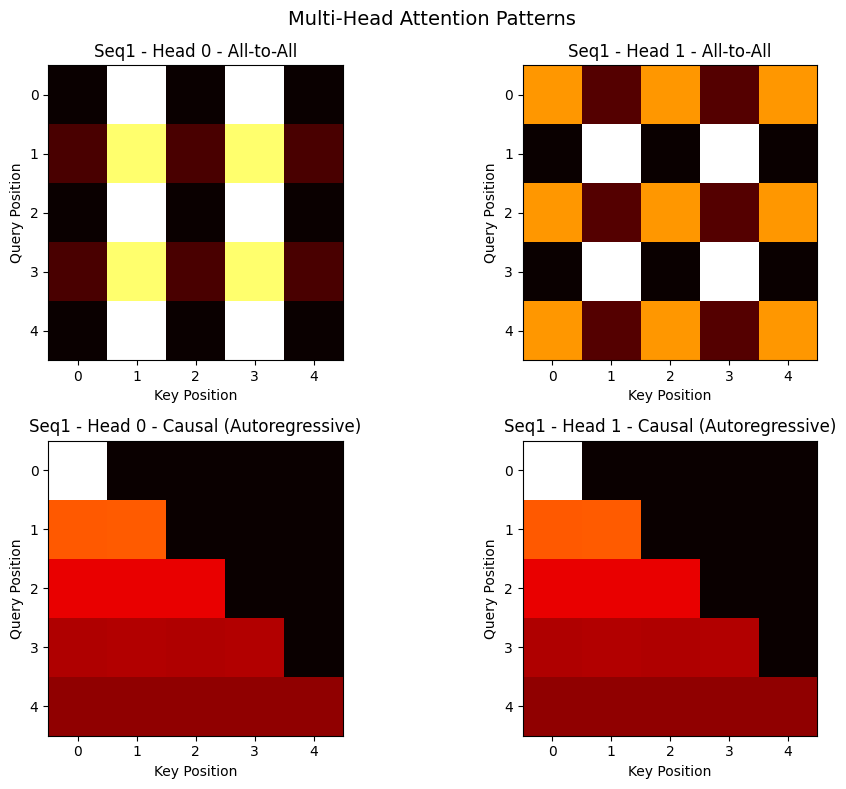

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Seq 1, all-to-all
axes[0, 0].imshow(weights1[0], cmap='hot')
axes[0, 0].set_title('Seq1 - Head 0 - All-to-All')
axes[0, 0].set_ylabel('Query Position')
axes[0, 0].set_xlabel('Key Position')

axes[0, 1].imshow(weights1[1], cmap='hot')
axes[0, 1].set_title('Seq1 - Head 1 - All-to-All')
axes[0, 1].set_ylabel('Query Position')
axes[0, 1].set_xlabel('Key Position')

# Seq 1, causal
axes[1, 0].imshow(weights1_causal[0], cmap='hot')
axes[1, 0].set_title('Seq1 - Head 0 - Causal (Autoregressive)')
axes[1, 0].set_ylabel('Query Position')
axes[1, 0].set_xlabel('Key Position')

axes[1, 1].imshow(weights1_causal[1], cmap='hot')
axes[1, 1].set_title('Seq1 - Head 1 - Causal (Autoregressive)')
axes[1, 1].set_ylabel('Query Position')
axes[1, 1].set_xlabel('Key Position')

plt.suptitle('Multi-Head Attention Patterns', fontsize=14)
plt.tight_layout()
plt.savefig(artifacts_dir / 'attention_heatmaps.png', dpi=150, bbox_inches='tight')
print(f"Saved to {artifacts_dir / 'attention_heatmaps.png'}")
plt.show()

## 7. Key Insights: Why Attention Works

In [8]:
insights = {
    'attention_concept': [
        'Queries (Q): "What am I looking for?" (learned from x)',
        'Keys (K): "What do I represent?" (learned from x)',
        'Values (V): "What information do I carry?" (learned from x)',
        'Attention score: How relevant is each key to this query?',
        'Output: Weighted sum of values based on relevance',
    ],
    'gradient_flow': {
        'RNN': 'Gradients flow through recurrence: h_t -> h_{t-1} -> ... -> h_0 (exponential decay)',
        'Attention': 'Gradients flow directly through attention weights (stable)',
        'Advantage': 'Long sequences preserve gradient magnitude in transformers',
    },
    'parallelization': {
        'RNN': 'Must compute h_t before h_{t+1} (T sequential steps)',
        'Attention': 'All positions compute attention simultaneously (1 step)',
        'Speedup': 'Transformers are T times faster at training (assuming infinite compute)',
    },
    'multi_head': [
        'Different heads learn different patterns',
        'Head 0 might attend nearby (local context)',
        'Head 1 might attend specific tokens (query-key matching)',
        'Together, heads capture diverse dependencies',
        'Ensemble effect improves expressiveness',
    ],
    'causal_masking': [
        'For language modeling: position i should not see future tokens i+1, i+2, ...',
        'Causal mask enforces this by zeroing out future positions',
        'Enables autoregressive generation: sample next token given past',
        'At train time: model trains as if doing generation',
    ],
    'next_steps': [
        'Project 12.25: Embeddings (learning token representations)',
        'Project 12: Full Transformer (attention + FFN + residuals + norm)',
        'Project 14: Pretraining (seeing attention learn real patterns)',
    ],
}

with open(artifacts_dir / 'attention_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("\n=== ATTENTION CONCEPTS ===")
for concept in insights['attention_concept']:
    print(f"  • {concept}")

print("\n=== GRADIENT FLOW COMPARISON ===")
for key, val in insights['gradient_flow'].items():
    print(f"  {key:12s}: {val}")

print("\n=== PARALLELIZATION ===")
for key, val in insights['parallelization'].items():
    print(f"  {key:12s}: {val}")

print("\n=== MULTI-HEAD INTUITION ===")
for point in insights['multi_head']:
    print(f"  • {point}")

print("\n=== CAUSAL MASKING ===")
for point in insights['causal_masking']:
    print(f"  • {point}")


=== ATTENTION CONCEPTS ===
  • Queries (Q): "What am I looking for?" (learned from x)
  • Keys (K): "What do I represent?" (learned from x)
  • Values (V): "What information do I carry?" (learned from x)
  • Attention score: How relevant is each key to this query?
  • Output: Weighted sum of values based on relevance

=== GRADIENT FLOW COMPARISON ===
  RNN         : Gradients flow through recurrence: h_t -> h_{t-1} -> ... -> h_0 (exponential decay)
  Attention   : Gradients flow directly through attention weights (stable)
  Advantage   : Long sequences preserve gradient magnitude in transformers

=== PARALLELIZATION ===
  RNN         : Must compute h_t before h_{t+1} (T sequential steps)
  Attention   : All positions compute attention simultaneously (1 step)
  Speedup     : Transformers are T times faster at training (assuming infinite compute)

=== MULTI-HEAD INTUITION ===
  • Different heads learn different patterns
  • Head 0 might attend nearby (local context)
  • Head 1 might att

## 8. Summary & Bridge to Full Transformer

In [9]:
print("\n=== ATTENTION IS THE CORE INNOVATION ===")
print("""
Transformers = Attention + Positional Encoding + Feed-Forward + Residuals + LayerNorm + Stacking

Now that you understand attention:
  ✓ Scaled dot-product attention: learned content-based routing
  ✓ Multi-head: diverse pattern learning
  ✓ Causal masking: autoregressive generation
  ✓ Gradient flow: stable over long sequences
  ✓ Parallelization: train fast, sample slow

Project 12 becomes assembly:
  → Add positional embeddings (encode position)
  → Add FFN blocks (increase capacity)
  → Add residual connections (enable deep stacking)
  → Stack layers (increase depth)

That's it. You understand transformers now.
""")

print("\n=== EXERCISES ===")
print("""
1. Modify embedding initialization and watch attention weights change
2. Compare causal vs non-causal masks quantitatively (entropy of weights)
3. Visualize how attention updates the representation (x -> output)
4. Test with longer sequences (seq_len=100): does gradient flow stay stable?
5. Manually trace one query-key-value computation end-to-end
""")


=== ATTENTION IS THE CORE INNOVATION ===

Transformers = Attention + Positional Encoding + Feed-Forward + Residuals + LayerNorm + Stacking

Now that you understand attention:
  ✓ Scaled dot-product attention: learned content-based routing
  ✓ Multi-head: diverse pattern learning
  ✓ Causal masking: autoregressive generation
  ✓ Gradient flow: stable over long sequences
  ✓ Parallelization: train fast, sample slow

Project 12 becomes assembly:
  → Add positional embeddings (encode position)
  → Add FFN blocks (increase capacity)
  → Add residual connections (enable deep stacking)
  → Stack layers (increase depth)

That's it. You understand transformers now.


=== EXERCISES ===

1. Modify embedding initialization and watch attention weights change
2. Compare causal vs non-causal masks quantitatively (entropy of weights)
3. Visualize how attention updates the representation (x -> output)
4. Test with longer sequences (seq_len=100): does gradient flow stay stable?
5. Manually trace one qu